---
# **Text 2 Image with k-diffusion**
---
For one-off generation, you can change the prompt below in section 0, then select from top menu Kernel -> Restart & Run All. Wait for everything to finish and scroll down to the bottom for the results! This process should take around a minute or so.

Here is the ever so helpful promptbook https://dallery.gallery/the-dalle-2-prompt-book/

If you want to iterate, you can:
- edit section 0 
- run the cell in section 0
- run all cells with the exception of the final "kernel shutdown" step once
- re-edit section 0 and run cell at section 0
- scroll down to section 4, and run the cell after "Run Prompt"
- repeat previous 2 steps until satisfied


Just please make sure to shut down the kernel when you are all done :)


## 0. Enter prompt and other configs

In [1]:
prompt = "a Hong Kong minibus, in the style of henri rousseau"
scale = 12 #@param {type:"number"}
height = 512 #@param {type:"integer"}
width = 896 #@param {type:"integer"}
n_steps = 30 #@param {type:"slider", min:30, max:250, step:5}
n_images = 4 #@param {type:"integer"}
n_rows = 2 #@param {type:"integer"}
grid = "yes" #@param ["yes", "no"]
current_seed = 0


## 1. Setup

In [3]:
cd /workspace/repos/stable-diffusion

/workspace/repos/stable-diffusion


In [4]:
import argparse, os, sys, glob
import time
import torch
import numpy as np

from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange
from torchvision.utils import make_grid
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import contextmanager, nullcontext

import accelerate
import k_diffusion as K
import torch.nn as nn

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

In [5]:
def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())


def load_model_from_config(ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cuda:0")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    return sd

class CFGDenoiser(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.inner_model = model

    def forward(self, x, sigma, uncond, cond, cond_scale):
        x_in = torch.cat([x] * 2)
        sigma_in = torch.cat([sigma] * 2)
        cond_in = torch.cat([uncond, cond])
        uncond, cond = self.inner_model(x_in, sigma_in, cond=cond_in).chunk(2)
        return uncond + (cond - uncond) * cond_scale

def generate(opt,prompt,grid):
    accelerator = accelerate.Accelerator()
    device = accelerator.device
    images = []

    seeds = torch.randint(-2 ** 63, 2 ** 63 - 1, [accelerator.num_processes])
    torch.manual_seed(seeds[accelerator.process_index].item())

    batch_size = opt.n_samples
    n_rows = opt.n_rows if opt.n_rows > 0 else batch_size

    assert prompt is not None
    data = [batch_size * [prompt]]

    start_code = torch.randn([opt.n_samples, opt.C, opt.H // opt.f, opt.W // opt.f], device=device)

    precision_scope = autocast if opt.precision=="autocast" else nullcontext
    with torch.no_grad():
        all_samples = list()
        with precision_scope("cuda"):
            for n in trange(opt.n_iter, desc="Sampling", disable =not accelerator.is_main_process):
                for prompts in tqdm(data, desc="data", disable =not accelerator.is_main_process):
                    #modelCS.to(device)
                    uc = None
                    if opt.scale != 1.0:
                        uc = modelCS.get_learned_conditioning(batch_size * [""])
                    if isinstance(prompts, tuple):
                        prompts = list(prompts)

                    c = modelCS.get_learned_conditioning(prompts)
                    shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
                    #mem = torch.cuda.memory_allocated()/1e6
                    #modelCS.to("cpu")
                    #while(torch.cuda.memory_allocated()/1e6 >= mem):
                    #    time.sleep(1)

                    sigmas = model_wrap.get_sigmas(opt.ddim_steps)
                    torch.manual_seed(opt.seed)
                    x = torch.randn([opt.n_samples, *shape], device=device) * sigmas[0] # for GPU draw
                    model_wrap_cfg = CFGDenoiser(model_wrap)
                    extra_args = {'cond': c, 'uncond': uc, 'cond_scale': opt.scale}
                    samples_ddim = K.sampling.sample_lms(model_wrap_cfg, x, sigmas, extra_args=extra_args, disable=not accelerator.is_main_process)
                    
                    #modelFS.to(device)
                    for i in range(batch_size):
                        x_samples_ddim = modelFS.decode_first_stage(samples_ddim[i].unsqueeze(0))
                        x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
                        x_sample = accelerator.gather(x_samples_ddim)
                        if grid:
                            all_samples.append(x_sample)
                        x_sample = 255. * rearrange(x_sample[0].cpu().numpy(), 'c h w -> h w c')
                        images +=[Image.fromarray(x_sample.astype(np.uint8))]
                    #mem = torch.cuda.memory_allocated()/1e6
                    #modelFS.to("cpu")
                    #while(torch.cuda.memory_allocated()/1e6 >= mem):
                    #    time.sleep(1)

                    del samples_ddim
            if grid:
                grid = torch.stack(all_samples, 0)
                grid = rearrange(grid, 'n b c h w -> (n b) c h w')
                grid = make_grid(grid, nrow=n_rows)
                grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
                images = [Image.fromarray(grid.astype(np.uint8))] + images

            print(f'Finished!')
            return images

## 2. Load Model

In [6]:
ckpt = '/mnt/sd-v1-4.ckpt' # this points to the model that is in your root gdrive folder

sd = load_model_from_config(f"{ckpt}")
li = []
lo = []
for key, value in sd.items():
    sp = key.split('.')
    if(sp[0]) == 'model':
        if('input_blocks' in sp):
            li.append(key)
        elif('middle_block' in sp):
            li.append(key)
        elif('time_embed' in sp):
            li.append(key)
        else:
            lo.append(key)
for key in li:
    sd['model1.' + key[6:]] = sd.pop(key)
for key in lo:
    sd['model2.' + key[6:]] = sd.pop(key)

Loading model from /mnt/sd-v1-4.ckpt
Global Step: 470000


## 3. Settings

In [7]:
class config():
      def __init__(self):
        self.config = 'optimizedSD/v1-inference.yaml' # Don't change this
        self.ckpt = ckpt # If you want to change the model location, change it on the Load movel section

        self.precision = 'autocast' # Change to full and fuck your RAM
        self.ddim_eta = 0.0 # Does nothing, keep as is
        self.C = 4 # Keep as is

        self.seed = 435455 #replaced later. not used

        self.ddim_steps = 30 # Keep within 30 ~ 250, higher is better but slower
        self.H = 256 # Height, the vertical resolution
        self.W = 256 # Width, the horizontal resolution
        self.f = 8 # Visual scale maybe, 256x256 with f = 4 seems to use same RAM as 512x512 with f = 8
        self.scale = 7.5 # Keep within 4 ~ 25, maybe, changes how the prompt is interpreted

        self.n_iter = 1 # Maybe improves it, reccomended to keep as is as it multiplies the waiting time
        self.n_samples = 4 # Amount of images outputted
        self.n_rows = 2 # How many images per row (used on grid)

opt = config()
seed_everything(opt.seed)

Global seed set to 435455


435455

In [8]:
config = OmegaConf.load(f"{opt.config}")
config.modelUNet.params.ddim_steps = opt.ddim_steps

model = instantiate_from_config(config.modelUNet)
_, _ = model.load_state_dict(sd, strict=False)
model.eval()
    
modelCS = instantiate_from_config(config.modelCondStage)
_, _ = modelCS.load_state_dict(sd, strict=False)
modelCS.eval()
modelCS.to('cuda')

modelFS = instantiate_from_config(config.modelFirstStage)
_, _ = modelFS.load_state_dict(sd, strict=False)
modelFS.eval()
modelFS.to('cuda')

if opt.precision == "autocast":
    model.half()
    modelCS.half()

model_wrap = K.external.CompVisDenoiser(model)
sigma_min, sigma_max = model_wrap.sigmas[0].item(), model_wrap.sigmas[-1].item()

UNet: Running in eps-prediction mode
Selected timesteps for ddim sampler: [  1  34  67 100 133 166 199 232 265 298 331 364 397 430 463 496 529 562
 595 628 661 694 727 760 793 826 859 892 925 958 991]
Selected alphas for ddim sampler: a_t: tensor([0.9983, 0.9679, 0.9332, 0.8942, 0.8513, 0.8049, 0.7552, 0.7031, 0.6490,
        0.5939, 0.5383, 0.4832, 0.4293, 0.3773, 0.3279, 0.2817, 0.2391, 0.2003,
        0.1657, 0.1352, 0.1087, 0.0862, 0.0673, 0.0518, 0.0392, 0.0292, 0.0214,
        0.0154, 0.0109, 0.0075, 0.0051]); a_(t-1): [0.99914998 0.99829602 0.96788138 0.93315113 0.89422345 0.85133696
 0.80485046 0.75523835 0.70307994 0.6490435  0.59386486 0.53832245
 0.48320839 0.42929849 0.37732267 0.32793713 0.28170055 0.23905578
 0.20031808 0.16567042 0.13516618 0.10873855 0.08621547 0.06733901
 0.05178706 0.03919602 0.02918243 0.0213625  0.0153683  0.01086013
 0.00753477]
For the chosen value of eta, which is 0.0, this results in the following sigma_t schedule for ddim sampler tensor([0., 0.

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.3.layer_norm1.bias', 'vision_model.post_layernorm.bias', 'vision_model.encoder.layers.11.mlp.fc1.bias', 'vision_model.encoder.layers.16.layer_norm2.weight', 'vision_model.encoder.layers.5.mlp.fc2.bias', 'vision_model.encoder.layers.13.self_attn.out_proj.weight', 'vision_model.encoder.layers.17.self_attn.k_proj.weight', 'vision_model.encoder.layers.3.mlp.fc1.bias', 'vision_model.encoder.layers.6.mlp.fc2.weight', 'vision_model.encoder.layers.19.self_attn.k_proj.bias', 'vision_model.encoder.layers.4.self_attn.v_proj.weight', 'vision_model.encoder.layers.19.self_attn.q_proj.bias', 'vision_model.encoder.layers.19.self_attn.v_proj.weight', 'vision_model.encoder.layers.8.mlp.fc2.weight', 'vision_model.encoder.layers.7.self_attn.k_proj.weight', 'vision_model.encoder.layers.11.mlp.fc2.bias', 'vision_model.encoder.layers.1.layer_norm2.weight', 'vision

FirstStage: Running in eps-prediction mode
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


## 4. Run Prompt

In [9]:
opt.scale = scale
opt.H = height
opt.W = width
opt.n_samples = n_images
opt.n_rows = n_rows
opt.ddim_steps = n_steps
opt.seed = current_seed
images = generate(opt=opt, prompt=prompt, grid=(grid=="yes"))

data:   0%|                                                                                                                                                                           | 0/1 [00:00<?, ?it/s]


Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:39<00:00, 39.02s/it]

Finished!


## Output

If you generated more than 5 images(the grid counts too), just add more code lines continuing the sequence

If you chose grid, it's the first one

Right click and save to download

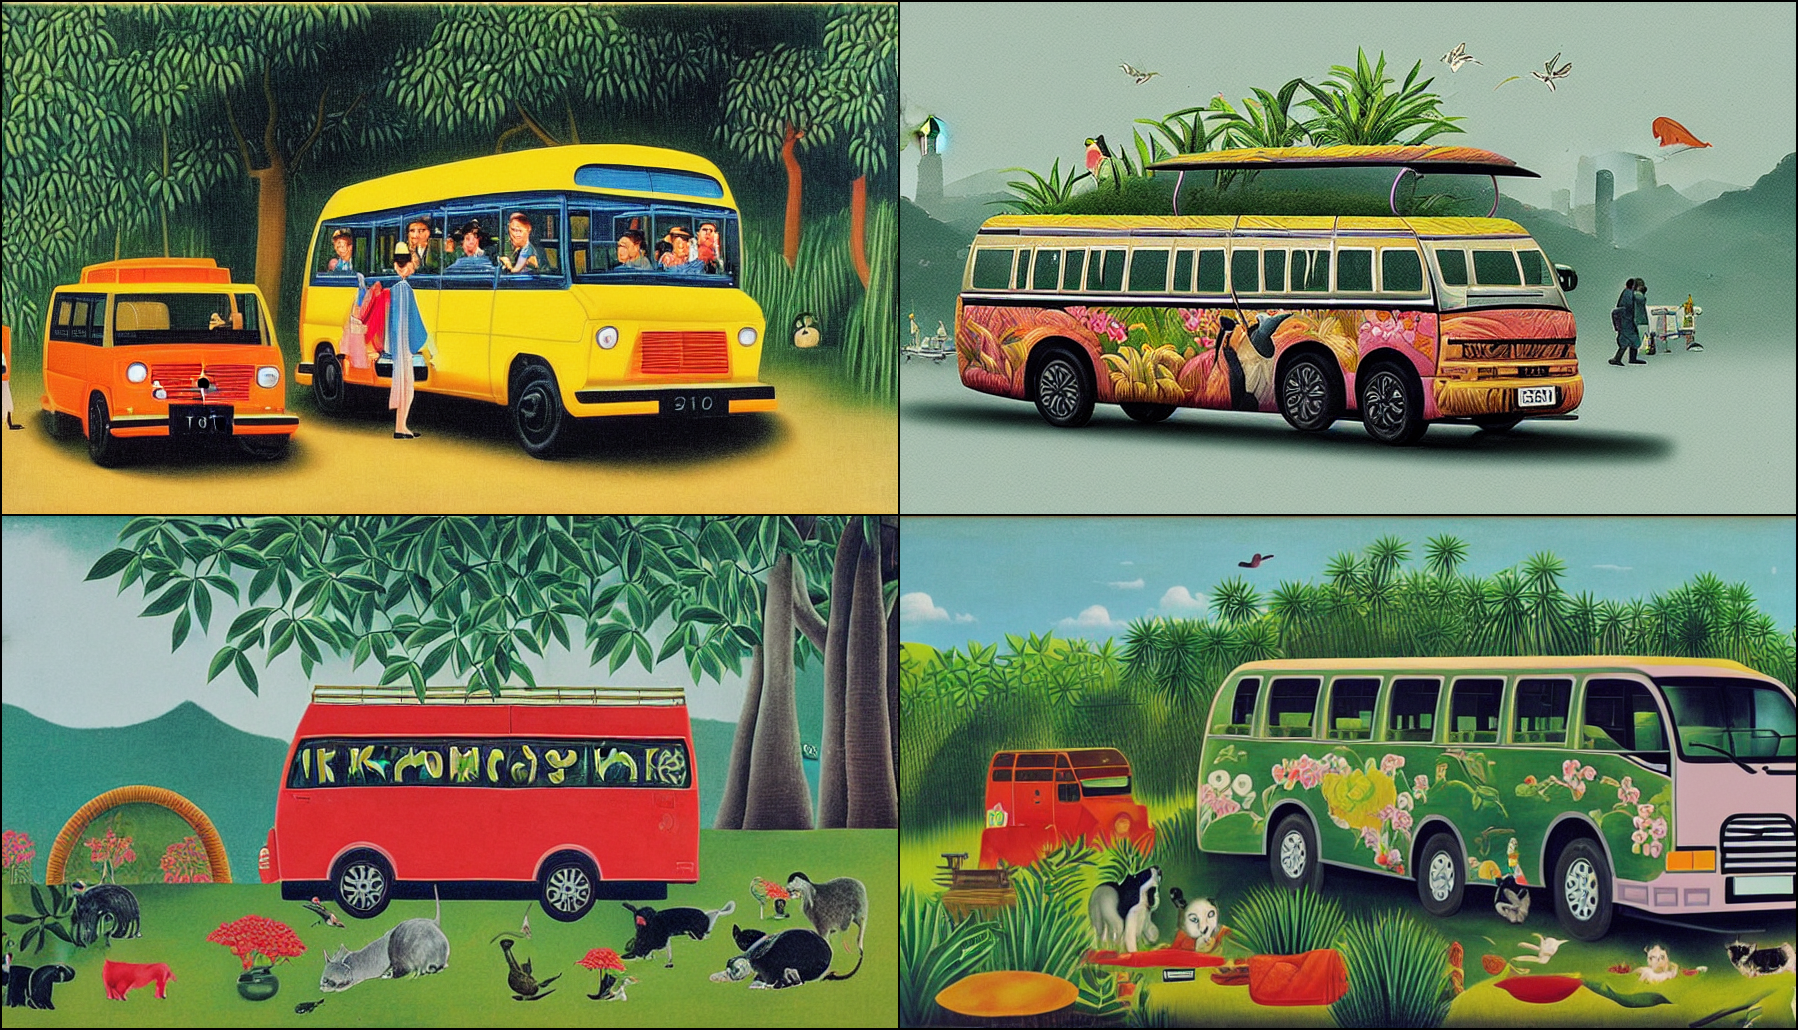

In [10]:
images[0]

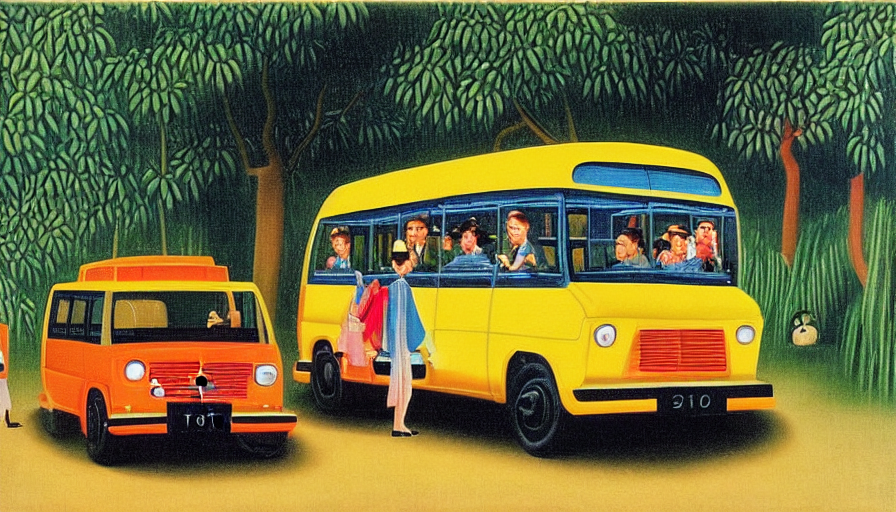

In [11]:
#use this to get a single image, indexed starting at 1
images[1]

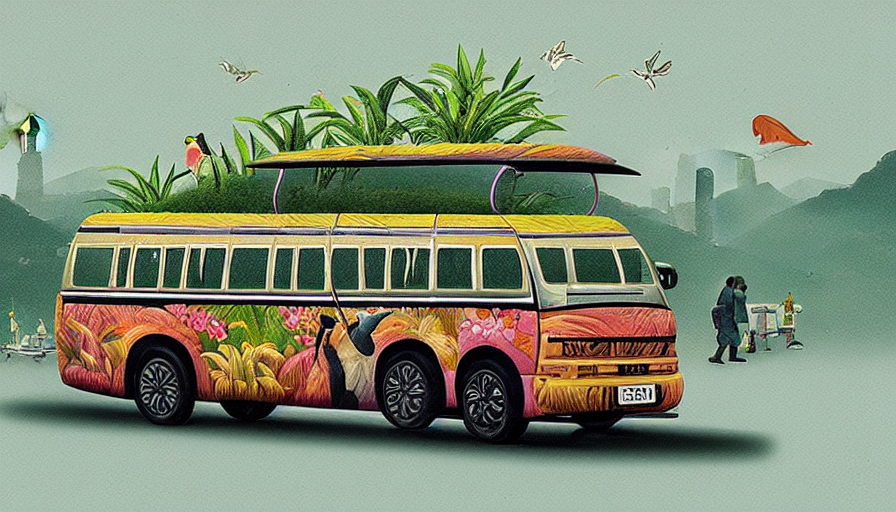

In [12]:
images[2]

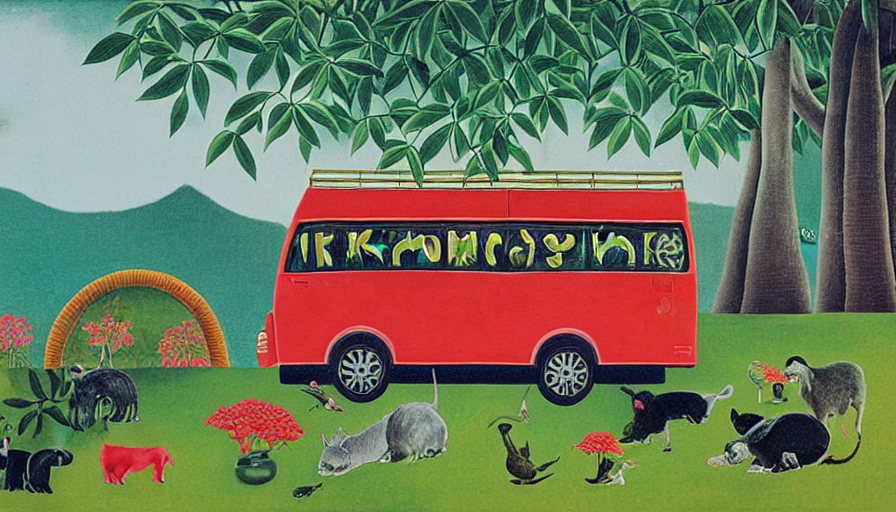

In [13]:
images[3]

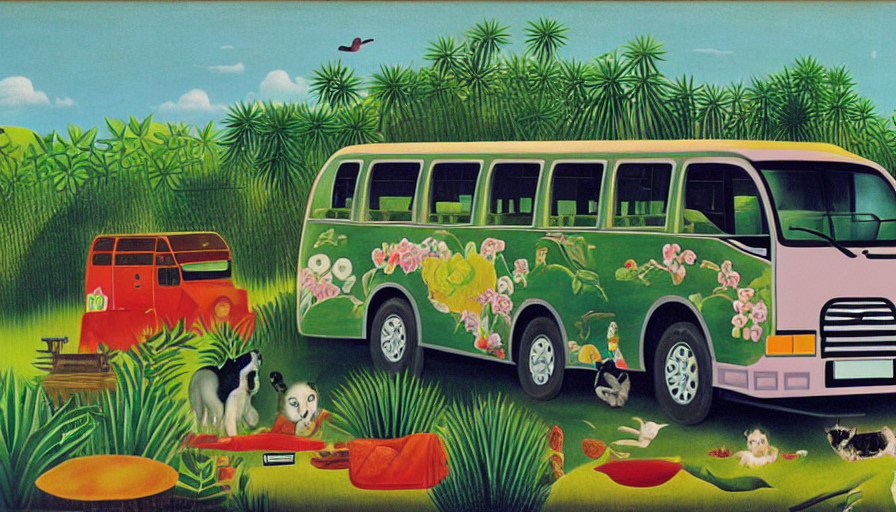

In [14]:
images[4]

# Final step: shutting down kernel

In [15]:
#shutdown kernel
import IPython
IPython.Application.instance().kernel.do_shutdown(False) 

{'status': 'ok', 'restart': False}